In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

%matplotlib inline

# Preliminaries.

In [2]:
fs = 22050.
fs2 = fs / 2.
duration = 1.
noise_amplitude = 1.
signal_amplitude = 30000.

def plot(x):
    plt.figure(figsize=(15, 4))
    indices = np.arange(len(x))
    plt.plot(indices, x)
    plt.show()
    
class Bunch:
    
    def __init__(self, *args, **kwargs):
        for arg in args:
            self.__dict__.update(arg.__dict__)
        self.__dict__.update(kwargs)
        
    def __eq__(self, other):
        if not isinstance(other, Bunch):
            return False
        else:
            return self.__dict__ == other.__dict__
        
_SAMPLE_RATE = 22050.
_NOISE_AMPLITUDE = 2.

_SIMPLE_NOISE_BURST_SETTINGS = Bunch(
    sample_rate=_SAMPLE_RATE,
    noise_amplitude=_NOISE_AMPLITUDE,
    duration=4.,
    burst_amplitude=30000.,
    first_burst_start_time=1.,
    burst_period=1.,
    burst_durations=(.1, .1, .1)
)

_INCREASING_DURATION_NOISE_BURST_SETTINGS = Bunch(
    sample_rate=_SAMPLE_RATE,
    noise_amplitude=_NOISE_AMPLITUDE,
    duration=32.,
    burst_amplitude=30000.,
    first_burst_start_time=2.,
    burst_period=2.,
    burst_durations=.05 * np.arange(1, 16)
)

_INTEGRATION_TIME_IMPULSE_SETTINGS = Bunch(
    sample_rate=_SAMPLE_RATE,
    noise_amplitude=_NOISE_AMPLITUDE,
    duration=2.,
    first_impulse_time=1.,
    first_impulse_amplitude=1000.,
    second_impulse_offset=1800,
    second_impulse_amplitude=30000.
)

_IMPULSE_SETTINGS = Bunch(
    sample_rate=_SAMPLE_RATE,
    noise_amplitude=_NOISE_AMPLITUDE,
    duration=4.,
    impulse_amplitude=30000.,
    impulse_times=[1, 2, 3]
)

_SENTINEL_SETTINGS = Bunch(
    sample_rate=_SAMPLE_RATE,
    noise_amplitude=_NOISE_AMPLITUDE,
    duration=10.,
    sentinel_amplitude=30000.,
    sentinel_start_offset=8.,
    sentinel_duration=.25,
    sentinel_length=10
)

_DETECTOR_SETTINGS = Bunch(
    sample_rate=_SAMPLE_RATE,
    f0=6000,
    f1=10000,
    bw=100,
    filter_length=99,
    integration_length=2000,
    delay=.020,
    threshold=2.,
    min_duration=.100,
    max_duration=.400,
    start_offset=-560,
    padding=3000
)

def _create_test_signal(signal_generator, settings):

    s = settings
        
    np.random.seed(0)

    # generate background noise
    length = int(round(s.duration * s.sample_rate))
    samples = _create_noise(length, s.noise_amplitude)
    
    # append sentinel
    samples = _append_sentinel(samples, _SENTINEL_SETTINGS)
        
    # invoke signal generator
    samples = signal_generator(samples, settings)
    
    return np.array(samples, dtype=np.dtype('<i2'))


def _create_noise(length, amplitude=1):
    a = 2 * amplitude
    b = -amplitude
    return a * np.random.random(length) + b


def _append_sentinel(samples, settings):
    
    s = settings
    
    # create background noise
    length = int(round(s.duration * s.sample_rate))
    sentinel = _create_noise(length, s.noise_amplitude)
    
    # add transient whose first ten samples are 30000
    i = int(round(s.sentinel_start_offset * s.sample_rate))
    n = int(round(s.sentinel_duration * s.sample_rate))
    sentinel[i:i + n] =_create_noise(n, s.sentinel_amplitude)
    sentinel[i:i + s.sentinel_length] = s.sentinel_amplitude
    
    return np.concatenate((samples, sentinel))
    

def _add_noise_bursts(samples, settings):
    
    s = settings
    
    amplitude = s.burst_amplitude
    
    for i, duration in enumerate(s.burst_durations):
        
        start_time = s.first_burst_start_time + i * s.burst_period
        end_time = start_time + duration
        
        start_index = int(round(start_time * s.sample_rate))
        end_index = int(round(end_time * s.sample_rate))
        length = end_index - start_index
        
        samples[start_index:end_index] = _create_noise(length, amplitude)
        
    return samples
        
        
def _add_impulses(samples, settings):
    
    s = settings
    
    for time in s.impulse_times:
        index = int(round(time * s.sample_rate))
        samples[index] = s.impulse_amplitude

    return samples


def _add_integration_time_impulses(samples, settings):
    
    s = settings
    
    index = int(round(s.first_impulse_time * s.sample_rate))
    samples[index] = s.first_impulse_amplitude
    
    index += s.second_impulse_offset
    samples[index] = s.second_impulse_amplitude

    return samples


def _create_integration_time_test_signal():
    
    s = Bunch(
        sample_rate=_SAMPLE_RATE,
        initial_noise_amplitude=200,
        final_noise_amplitude=100,
        noise_ramp_length=10000,
        duration=3,
        impulse_time=2,
        impulse_amplitude=2531 # tripping point
    )

    np.random.seed(0)
    
    # Find signal event indices.
    impulse_index = int(round(s.impulse_time * s.sample_rate))
    noise_ramp_start_index = impulse_index - s.noise_ramp_length
    
    # Generate constant amplitude background noise.
    length = int(round(s.duration * s.sample_rate))
    samples = _create_noise(length, s.initial_noise_amplitude)
    
    # Shape noise amplitude.
    length = impulse_index - noise_ramp_start_index
    ramp = np.arange(length) / float(length)
    ratio = s.final_noise_amplitude / s.initial_noise_amplitude
    samples[noise_ramp_start_index:impulse_index] *= 1 + ramp * (ratio - 1)
    samples[impulse_index:] *= ratio
    
    # Add impulse.
    samples[impulse_index] = s.impulse_amplitude
    
    # append sentinel
    samples = _append_sentinel(samples, _SENTINEL_SETTINGS)
    
    return np.array(samples, dtype=np.dtype('<i2'))

# Plot integration time test signal.

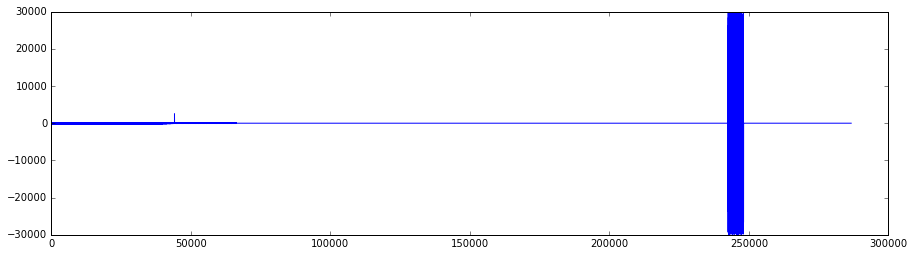

In [3]:
x = _create_integration_time_test_signal()
plot(x)

# Create test signal.

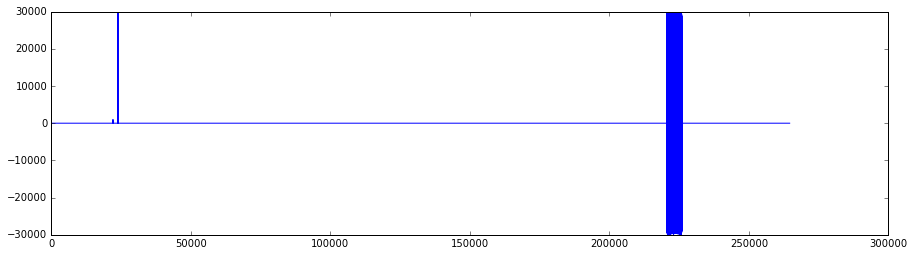

In [4]:
# n = round(duration * fs)
# np.random.seed(0)
# x = noise_amplitude * (-1 + 2 * np.random.random(n))
# # ranges = [(.2, .3), (.5, .6), (.8, .9)]
# # for start, end in ranges:
# #     s = round(start * fs)
# #     e = round(end * fs)
# #     x[s:e] *= signal_amplitude / noise_amplitude
# times = [.2, .5, .8]
# for t in times:
#     i = round(t * fs)
#     x[i] = 30000
# plot(x)
# sound = x

# x = _create_test_signal(_add_noise_bursts, _SIMPLE_NOISE_BURST_SETTINGS)
# x = _create_test_signal(_add_noise_bursts, _INCREASING_DURATION_NOISE_BURST_SETTINGS)
x = _create_test_signal(_add_integration_time_impulses, _INTEGRATION_TIME_IMPULSE_SETTINGS)
# x = _create_test_signal(_add_impulses, _IMPULSE_SETTINGS)
plot(x)
sound = x

# Design filter.

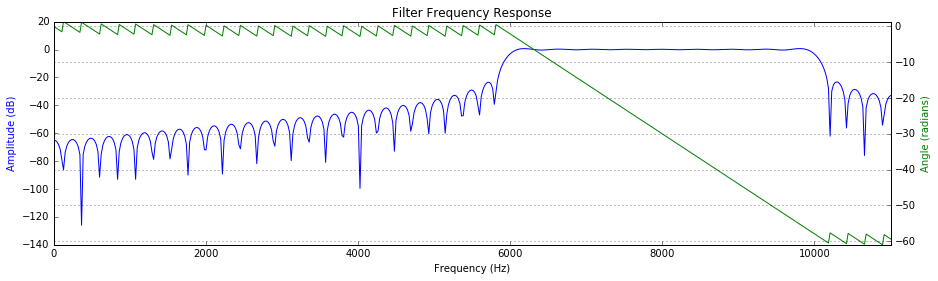

In [5]:
# Design filter.
filter_length = 99
f0 = 6000
f1 = 10000
bw = 100
bands = np.array([0, f0 - bw, f0, f1, f1 + bw, fs2]) / fs2
desired = np.array([0, 0, 1, 1, 0, 0])
coeffs = signal.firls(filter_length, bands, desired)

# Get frequency response.
w, h = signal.freqz(coeffs)
w *= fs / (2 * np.pi)


# Plot frequency response.

figure = plt.figure(figsize=(15, 4))
plt.title('Filter Frequency Response')

ax1 = figure.add_subplot(111)
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude (dB)', color='b')
plt.xlabel('Frequency (Hz)')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')

plt.grid()
plt.axis('tight')
plt.show()

# Apply filter.

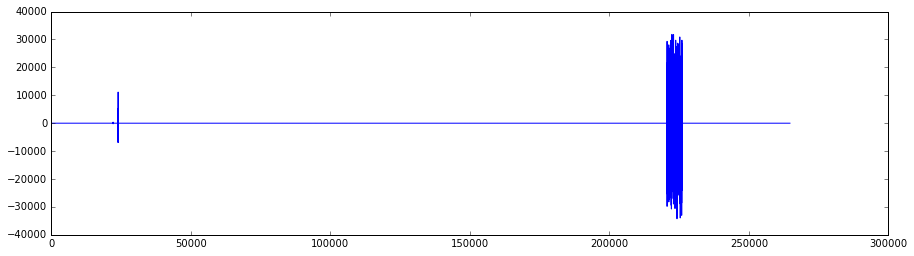

In [6]:
x = signal.fftconvolve(x, coeffs)
plot(x)

# Take magnitude squared.

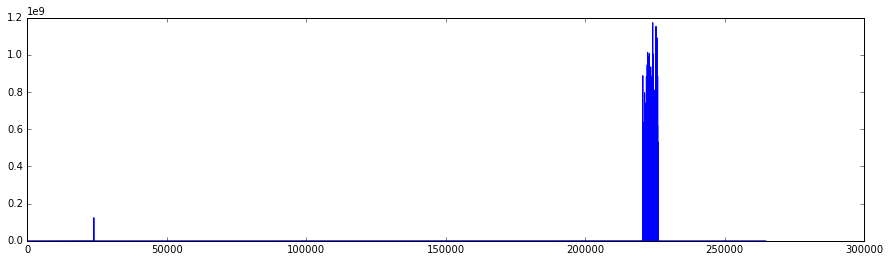

In [7]:
x = x * x
plot(x)

# Integrate.

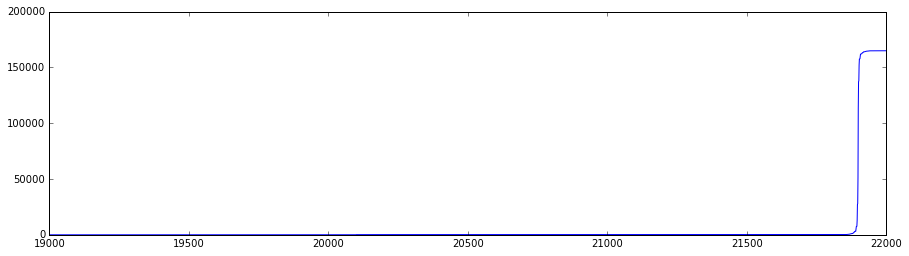

In [8]:
integration_length = 2000
x = np.cumsum(x)
x = (x[integration_length:] - x[:-integration_length]) / integration_length
plt.figure(figsize=(15, 4))
indices = np.arange(len(x))
plt.plot(indices, x)
#plt.xlim([20000, 20200])
plt.xlim([19000, 22000])
plt.ylim([0, 200000])
plt.show()

# Take ratios.

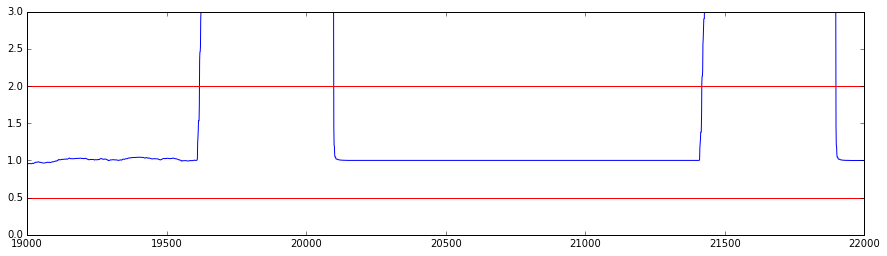

In [9]:
DELAY = .020
THRESHOLD = 2

delay = round(DELAY * fs)
threshold = THRESHOLD

x = x[delay:] / x[:-delay]
plt.figure(figsize=(15, 4))
indices = np.arange(len(x))
plt.plot(indices, x)
plt.xlim([19000, 22000])
plt.ylim([0, 3])
plt.axhline(threshold, color='r')
plt.axhline(1. / threshold, color='r')
plt.show()

# Compare ratios to threshold.

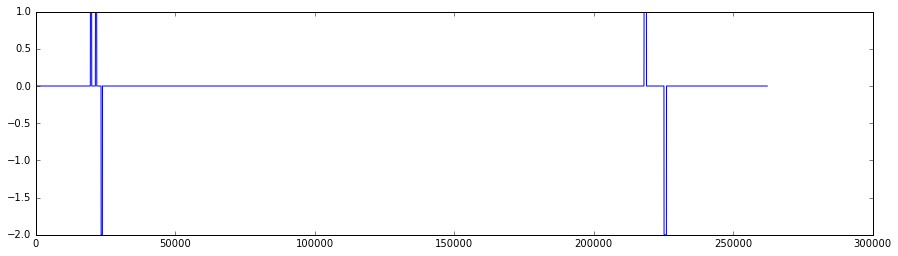

In [10]:
xx = np.zeros(len(x))
xx[x > threshold] = 1
xx[x < 1. / threshold] = -2
x = xx
plot(x)

# Find outward-going threshold crossing events.

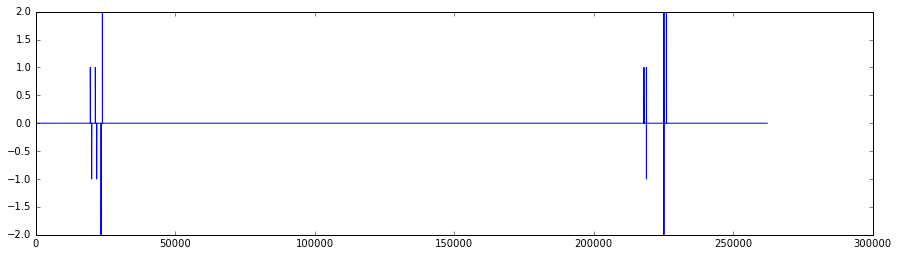

In [11]:
x = x[1:] - x[:-1]
plot(x)

In [12]:
rises = np.where(x == 1)[0]
falls = np.where(x == -2)[0]
print(rises)
print(falls)

[ 19617  21417 218058 218944]
[ 23457 225221 225236]


In [13]:
events = sorted([(r, True) for r in rises] + [(f, False) for f in falls])
print(events)

[(19617, True), (21417, True), (23457, False), (218058, True), (218944, True), (225221, False), (225236, False)]


# Parse crossing events into detection pulses.

emit (19617, 3840)
emit (218058, 7163)


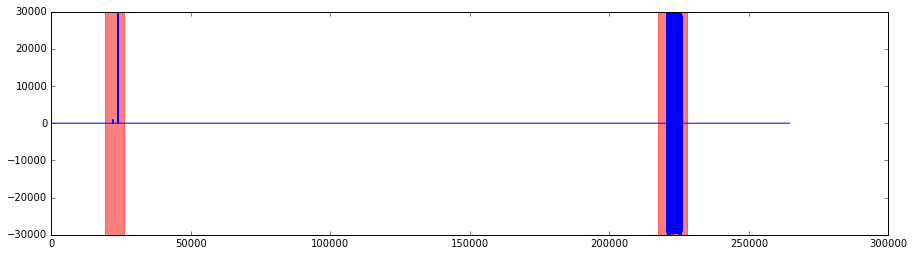

In [14]:
MIN_DURATION = .100
MAX_DURATION = .400
LAG = 3000
DELAY = -560

STATE_DOWN = 0
STATE_UP = 1
STATE_HOLDING = 2

def emit_pulses(events):
    
    min_length = round(MIN_DURATION * fs)
    max_length = round(MAX_DURATION * fs)

    state = STATE_DOWN

    start_index = 0
    """index of start of current pulse."""

    for index, rise in events:

        if state == STATE_DOWN:

            if rise:
                # rise while down

                # Start new pulse.
                start_index = index
                state = STATE_UP

            # Do nothing for fall while down.

        elif state == STATE_UP:

            if rise:
                # rise while up

                if index > start_index + max_length:
                    # rise after end of maximal pulse

                    # Emit maximal pulse.
                    emit_pulse(start_index, max_length)

                    # Start new pulse.
                    start_index = index

                # Do nothing for rise before end of maximal pulse.

            else:
                # fall while up

                if index < start_index + min_length:
                    # fall before end of minimal pulse

                    state = STATE_HOLDING

                else:
                    # fall at or after end of minimal pulse

                    length = index - start_index

                    # Truncate pulse if after end of maximal pulse.
                    if length > max_length:
                        length = max_length

                    emit_pulse(start_index, length)
                    state = STATE_DOWN

        else:
            # holding short pulse

            if rise:
                # rise while holding short pulse

                if index > start_index + min_length:
                    # rise after end of minimal pulse

                    # Emit minimal pulse.
                    emit_pulse(start_index, min_length)

                    # Start new pulse.
                    start_index = index
                    state = STATE_UP

                # Do nothing for rise at or before end of minimal pulse.

            else:
                # fall while holding short pulse

                if index >= start_index + min_length:
                    # fall at or after end of minimal pulse

                    # Emit minimal pulse.
                    emit_pulse(start_index, min_length)

                    state = STATE_DOWN

                # Do nothing for fall before end of minimal pulse.

intervals = []

def emit_pulse(start_index, length):
    start = start_index + DELAY
    end = start + length + LAG
    intervals.append((start, end))
    print('emit ({}, {})'.format(start_index, length))
    
emit_pulses(events)

plt.figure(figsize=(15, 4))
indices = np.arange(len(sound))
plt.plot(indices, sound)
for start, end in intervals:
    plt.axvspan(start, end, color='red', alpha=0.5)
plt.show()